# QOSF Mentorship Screening Task 2020
## Task 2
Find the lowest eigenvalue of the following matrix

$\begin{bmatrix}1 &0 &0 &0 \\ 
0 &0 &-1 &0 \\
0 &-1 &0 &0 \\
0 &0 &0 &1
\end{bmatrix}$


using VQE-like circuits, created by yourself from scratch.

**Solution** by Sadman Ahmed Shanto (Sept 2020)

## High Level Structure of Solution
* Break down matrix into weighted sums of Pauli terms
* Define a sensible ansatz needed for state preparation (used the one provided in the hints)
* Define methods to compute expected value from sum of Pauli terms
* Compute the expectation values for $0 \ge \theta \le 2\pi$
* The smallest eigenvalue is the ``` min(expected_values_list)```

Implementing methods to calculate Hilbert-Schmidt-Product and Decompose the *4x4* Hermitian matrix into Pauli matrices

In [25]:
import numpy as np

def HS(M1, M2):
    """Hilbert-Schmidt-Product of two matrices M1, M2"""
    return (np.dot(M1.conjugate().transpose(), M2)).trace()

def c2s(c):
    """Return a string representation of a complex number c"""
    if c == 0.0:
        return "0"
    if c.imag == 0:
        return "%g" % c.real
    elif c.real == 0:
        return "%gj" % c.imag
    else:
        return "%g+%gj" % (c.real, c.imag)

def decompose(H):
    """Decompose Hermitian 4x4 matrix H into Pauli matrices"""
    from numpy import kron
    sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)
    S = [id, sx, sy, sz]
    labels = ['I', 'sigma_x', 'sigma_y', 'sigma_z']
    for i in range(4):
        for j in range(4):
            label = labels[i] + ' \otimes ' + labels[j]
            a_ij = 0.25 * HS(kron(S[i], S[j]), H)
            if a_ij != 0.0:
                print("%s\t*\t( %s )" % (c2s(a_ij), label))

Let M be the given matrix

$$ M = \begin{bmatrix}1 &0 &0 &0 \\ 
0 &0 &-1 &0 \\
0 &-1 &0 &0 \\
0 &0 &0 &1
\end{bmatrix}$$

In [138]:
M = np.matrix([[1, 0, 0, 0], [0, 0, -1, 0],[0, -1, 0, 0],[0, 0, 0, 1]]).A
M

array([[ 1,  0,  0,  0],
       [ 0,  0, -1,  0],
       [ 0, -1,  0,  0],
       [ 0,  0,  0,  1]])

In [139]:
decompose(M)

0.5	*	( I \otimes I )
-0.5	*	( sigma_x \otimes sigma_x )
-0.5	*	( sigma_y \otimes sigma_y )
0.5	*	( sigma_z \otimes sigma_z )


Thus, the given matrix is equal to $$ M = \begin{bmatrix}1 &0 &0 &0 \\ 
0 &0 &-1 &0 \\
0 &-1 &0 &0 \\
0 &0 &0 &1
\end{bmatrix} = 0.5 \sigma_i \otimes \sigma_i  - 0.5 \sigma_x \otimes \sigma_x  - 0.5 \sigma_y \otimes \sigma_y + 0.5 \sigma_z \otimes \sigma_z $$

Creating a PauliSum object in pyquil now.

In [268]:
A = PauliSum([PauliTerm.from_list([("I", 1), ("I", 0)], coefficient=0.5),
              PauliTerm.from_list([("X", 1), ("X", 0)], coefficient=-0.5),
              PauliTerm.from_list([("Y", 1), ("Y", 0)], coefficient=-0.5),
              PauliTerm.from_list([("Z", 1), ("Z", 0)], coefficient=0.5)
             ])
A

(0.5+0j)*I + (-0.5+0j)*X1*X0 + (-0.5+0j)*Y1*Y0 + (0.5+0j)*Z1*Z0

In [275]:
import numpy as np
import funcsigs
from collections import Counter
from typing import List, Union
from pyquil import Program
from pyquil.api import QuantumComputer, WavefunctionSimulator
from pyquil.api._qvm import QVM
from pyquil.gates import RX, RY, MEASURE, STANDARD_GATES
from pyquil.paulis import PauliTerm, PauliSum
from pyquil import Program, get_qc
from pyquil.gates import RX, I, H, CNOT, H

# Create connection with QVM
qc = get_qc('2q-qvm')

# Define ansatz
n_qubits, depth = 2, 4

def ansatz(params):
    p = Program()
    for i in range(depth):
        for j in range(n_qubits):
            p += Program(RX(params[j], j))
        p += CNOT(1,0)
        for j in range(n_qubits):
            p += Program(H(j))
    return p


def expectation(pyquil_prog: Program,
                    pauli_sum: Union[PauliSum, PauliTerm, np.ndarray],
                    samples: int,
                    qc: QuantumComputer) -> float:
        if isinstance(pauli_sum, np.ndarray):
            # debug mode by passing an array
            wf = WavefunctionSimulator().wavefunction(pyquil_prog)
            wf = np.reshape(wf.amplitudes, (-1, 1))
            average_exp = np.conj(wf).T.dot(pauli_sum.dot(wf)).real
            return average_exp
        else:
            if not isinstance(pauli_sum, (PauliTerm, PauliSum)):
                raise TypeError("pauli_sum variable must be a PauliTerm or PauliSum object")

            if isinstance(pauli_sum, PauliTerm):
                pauli_sum = PauliSum([pauli_sum])

            if samples is None:
                operator_progs = []
                operator_coeffs = []
                for p_term in pauli_sum.terms:
                    op_prog = Program()
                    for qindex, op in p_term:
                        op_prog.inst(STANDARD_GATES[op](qindex))
                    operator_progs.append(op_prog)
                    operator_coeffs.append(p_term.coefficient)

                result_overlaps = WavefunctionSimulator().expectation(pyquil_prog, pauli_sum.terms)
                result_overlaps = list(result_overlaps)
                assert len(result_overlaps) == len(operator_progs),\
                    """Somehow we didn't get the correct number of results back from the QVM"""
                expectation = sum(list(map(lambda x: x[0] * x[1],
                                           zip(result_overlaps, operator_coeffs))))
                return expectation.real
            else:
                if not isinstance(samples, int):
                    raise TypeError("samples variable must be an integer")
                if samples <= 0:
                    raise ValueError("samples variable must be a positive integer")

                # normal execution via fake sampling
                # stores the sum of contributions to the energy from each operator term
                expectation = 0.0
                for j, term in enumerate(pauli_sum.terms):
                    meas_basis_change = Program()
                    qubits_to_measure = []
                    if term.id() == "":
                        meas_outcome = 1.0
                    else:
                        for index, gate in term:
                            qubits_to_measure.append(index)
                            if gate == 'X':
                                meas_basis_change.inst(RY(-np.pi / 2, index))
                            elif gate == 'Y':
                                meas_basis_change.inst(RX(np.pi / 2, index))

                            meas_outcome = \
                                expectation_from_sampling(pyquil_prog + meas_basis_change,
                                                          qubits_to_measure,
                                                          qc,
                                                          samples)

                    expectation += term.coefficient * meas_outcome

                return expectation.real


def expectation_from_sampling(pyquil_program: Program,
                              marked_qubits: List[int],
                              qc: QuantumComputer,
                              samples: int) -> float:
    program = Program()
    ro = program.declare('ro', 'BIT', max(marked_qubits) + 1)
    program += pyquil_program
    program += [MEASURE(qubit, r) for qubit, r in zip(list(range(max(marked_qubits) + 1)), ro)]
    program.wrap_in_numshots_loop(samples)
    executable = qc.compile(program)
    bitstring_samples = qc.run(executable)
    bitstring_tuples = list(map(tuple, bitstring_samples))

    freq = Counter(bitstring_tuples)

    # perform weighted average
    expectation = 0
    for bitstring, count in freq.items():
        bitstring_int = int("".join([str(x) for x in bitstring[::-1]]), 2)
        if parity_even_p(bitstring_int, marked_qubits):
            expectation += float(count) / samples
        else:
            expectation -= float(count) / samples
    return expectation
            

def parity_even_p(state, marked_qubits):
    """
    Calculates the parity of elements at indexes in marked_qubits
    Parity is relative to the binary representation of the integer state.
    :param state: The wavefunction index that corresponds to this state.
    :param marked_qubits: The indexes to be considered in the parity sum.
    :returns: A boolean corresponding to the parity.
    """
    assert isinstance(state, int), \
        f"{state} is not an integer. Must call parity_even_p with an integer state."
    mask = 0
    for q in marked_qubits:
        mask |= 1 << q
    return bin(mask & state).count("1") % 2 == 0
    
            
# Function calculating expectation value
def getExpectationValue(params):
    
    # Define number of measurments
    samples = 10
    
    # Define program
    prog = ansatz(params)
    
    # Calculate expectation
    exp = expectation(prog,A,1,qc)
    return exp

# Test of expectation value function  
test = getExpectationValue([1.2,1.1]) 
print(test)

/Users/sshanto/anaconda3/lib/python3.8/site-packages/pyquil/paulis.py:183: FutureWarning: `PauliTerm.id()` will not work on PauliTerms where the qubits are not sortable and should be avoided in favor of `operations_as_set`.
  warnings.warn(


0.0


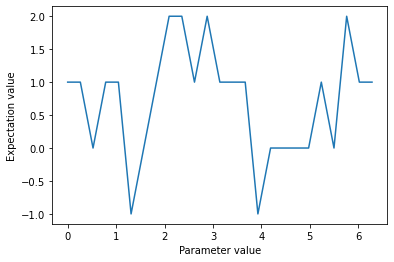

The lowest eigenvalue is -1.0


In [276]:
# Draw expectation alue against parameter value
params_range = np.linspace(0.0, 2 * np.pi, 25)
data = [getExpectationValue([params,params]) for params in params_range]

import matplotlib.pyplot as plt
plt.xlabel('Parameter value')
plt.ylabel('Expectation value')
plt.plot(params_range, data)
plt.show()

data.sort()
print("The lowest eigenvalue is {}".format(data[0]))

In [278]:
from numpy import linalg as LA

evs = LA.eig(M)
evs[0].sort()
print("We know from basic linear algebra that the lowest eigenvalue for M is {}".format(evs[0][0]))

We know from basic linear algebra that the lowest eigenvalue for M is -1.0
